In [1]:
from PIL import Image
import json
import os
import random
import pandas as pd
import re

In [20]:
image_folder='/rcfs/projects/steel_thread/hora620/hf/hub/datasets--CrowdAILab--scicap/snapshots/203770e81e7ff9facdd4a1b35048a3e3abf5ebcf/share-task-img-mask/arxiv/val'

In [ ]:
data_path='/rcfs/projects/steel_thread/hora620/hf/hub/datasets--CrowdAILab--scicap/snapshots/203770e81e7ff9facdd4a1b35048a3e3abf5ebcf/val.json'
scicap_val = json.load(open(data_path, "r"))
scicap_val_images=pd.DataFrame(scicap_val['images'])

scicap_val_annotations=pd.DataFrame(scicap_val['annotations'])


data_path='/qfs/projects/steel_thread/hora620/DevHub/scientific-instruction-tuning/Grounded-Segment-Anything/results/scicap_val/type_clf_llava_scicap_val_501_v2.json'
scipcap_preds = json.load(open(data_path, "r"))

In [10]:

data_path="/rcfs/projects/steel_thread/models/LLAVA-7b-pretrain-scitune-333472-v2-13B/scicap/llava_val_scicap_prediction_501_v2.jsonl"
scitune_preds=pd.read_json(data_path,lines=True)
# scitune_preds_with_gt=pd.merge(scitune_preds,scicap_val,left_on='question_id',right_on='id',how='inner')
# print(scitune_preds_with_gt.shape[0])

figure_types=['Graph Plot','Scatterplot','Node Diagram','Equation','Bar Chart']
def get_scitune_figure_tye_pred(text):
    for k in figure_types:
        if k in text:
            return k

scitune_preds['scitune_figure_type']=scitune_preds['text'].apply(get_scitune_figure_tye_pred)

In [11]:
import json
data_base_dir='/rcfs/projects/steel_thread/hora620/hf/hub/datasets--CrowdAILab--scicap/snapshots/203770e81e7ff9facdd4a1b35048a3e3abf5ebcf/'
with open(os.path.join(data_base_dir, f"llava_scicap_val_501_v2.json"), "r") as f:
        gt_scicap=json.load(f)
gt_scicap=pd.DataFrame(gt_scicap)

In [ ]:
gt_scicap.head()

## Figure Type Generation Performance

In [ ]:
clip_preds=[]
for pred in scipcap_preds:
    cip_pred={}
    cip_pred['id']=pred['id']
    type_clf_df=pd.DataFrame(pred['type_clf'])
    #print(type_clf_df.iloc[type_clf_df['score'].idxmax()])
    cip_pred['clip_figure_type']=type_clf_df.iloc[type_clf_df['score'].idxmax()]['label']
    clip_preds.append(cip_pred)
clip_preds=pd.DataFrame(clip_preds)
print(clip_preds.shape[0])

In [ ]:
scicap_val_with_preds=pd.merge(scicap_val_images,clip_preds,on='id',how='inner')
scicap_val_with_preds=pd.merge(scicap_val_with_preds,scitune_preds,left_on='id',right_on='question_id',how='inner')

In [ ]:
scicap_val_with_preds.head()

In [ ]:
scicap_val_with_preds['clip_accuracy']=(scicap_val_with_preds['figure_type']==scicap_val_with_preds['clip_figure_type']).astype(int)
scicap_val_with_preds['scitune_accuracy']=(scicap_val_with_preds['figure_type']==scicap_val_with_preds['scitune_figure_type']).astype(int)

In [ ]:
scicap_val_with_preds['clip_accuracy'].mean(),scicap_val_with_preds['scitune_accuracy'].mean()

In [ ]:
scicap_val_with_preds.groupby('figure_type')['clip_accuracy'].mean(),scicap_val_with_preds.groupby('figure_type')['scitune_accuracy'].mean()

## Figure Captioning

In [3]:
import evaluate
from tqdm import tqdm
tqdm.pandas()


/people/hora620/.conda/envs/llava-v1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:

bleu_metric = evaluate.load('google_bleu')
rouge_metric = evaluate.load('rouge')


In [ ]:
data_path='/qfs/projects/steel_thread/hora620/DevHub/scientific-instruction-tuning/Grounded-Segment-Anything/results/scicap_val/captions_llava_scicap_val_501_v2.json'
blip_preds = pd.DataFrame(json.load(open(data_path, "r")))

In [ ]:
scicap_val_images.head()

In [ ]:
scitune_preds_with_caption=pd.merge(scitune_preds,blip_preds,left_on='question_id',right_on='id')
scitune_preds_with_caption=pd.merge(scitune_preds_with_caption,scicap_val_annotations[['image_id','caption_no_index','paragraph','mention']],left_on='question_id',right_on='image_id')
scitune_preds_with_caption=pd.merge(scitune_preds_with_caption,scicap_val_images[['id','figure_type','ocr']],left_on='question_id',right_on='id')

In [ ]:
scitune_preds_with_caption['scitune_text']=scitune_preds_with_caption['text'].apply(lambda x:x.split('\n')[0])

In [ ]:
scitune_preds_with_caption.head()

In [ ]:

## only BLEU + ROUGE for time
metric_types = ['bleu', 'rouge']
metrics = [bleu_metric, rouge_metric]
metric_kwargs = [{}, {}]
metric_keys = ['google_bleu', 'rougeL']

pred_output_types = ['scitune_text', 'caption']
for pred_output_type in pred_output_types:
    for metric_type, metric_kwarg, metric, metric_key in zip(metric_types, metric_kwargs, metrics, metric_keys):
        metric_col = f'{pred_output_type}_{metric_type}'
#         if(metric_col not in results_outputs_with_metadata.columns):
        scitune_preds_with_caption = scitune_preds_with_caption.assign(**{
            metric_col : scitune_preds_with_caption.progress_apply(
                lambda x: metric.compute(
                    predictions=[x.loc[pred_output_type]], 
                    references=[[x.loc['caption_no_index']]],
                    **metric_kwarg
                )[metric_key], axis=1
            )
        })


In [ ]:

## just the caption
print("SciTune BLUE",scitune_preds_with_caption['scitune_text_bleu'].mean(),scitune_preds_with_caption['scitune_text_bleu'].std())
print("SciTune ROUGE",scitune_preds_with_caption['scitune_text_rouge'].mean(),scitune_preds_with_caption['scitune_text_rouge'].std())

print("BLIP BLUE",scitune_preds_with_caption['caption_bleu'].mean(),scitune_preds_with_caption['caption_bleu'].std())
print("BLIP ROUGE",scitune_preds_with_caption['caption_rouge'].mean(),scitune_preds_with_caption['caption_rouge'].std())

In [ ]:
# ## caption + OCR + mentions
# print("SciTune BLUE",scitune_preds_with_caption['text_bleu'].mean())
# print("SciTune ROUGE",scitune_preds_with_caption['text_rouge'].mean())

# print("BLIP BLUE",scitune_preds_with_caption['caption_bleu'].mean())
# print("BLIP ROUGE",scitune_preds_with_caption['caption_rouge'].mean())

In [ ]:
X=scitune_preds_with_caption[scitune_preds_with_caption['scitune_text_rouge']>0.25].sort_values(by='scitune_text_rouge',ascending=False)

In [ ]:
index=20
print("Image ID: ",X.iloc[index]['id'])
print("GT: ",X.iloc[index]['caption_no_index'])
print("BLIP: ",X.iloc[index]['caption'])
print("SciTune: ",X.iloc[index]['scitune_text'])
image_file=X.iloc[index]['image']
image = Image.open(os.path.join(image_folder, image_file)).convert('RGB')
image

## OCR and Paragraph Mentions

In [ ]:
gt_scicap.iloc[0]['conversations']

In [12]:
scitune_preds_with_gt_scicap=pd.merge(scitune_preds,gt_scicap,left_on='question_id',right_on='id')

In [13]:


scitune_preds_with_gt_scicap['gt_text']=scitune_preds_with_gt_scicap['conversations'].apply(lambda x: x[1]['value'])

In [14]:
scitune_preds_with_gt_scicap['scitune_text']=scitune_preds_with_gt_scicap['text'].apply(lambda x:"\n".join(x.split('\n')[1:]))
scitune_preds_with_gt_scicap['scitune_gt_text']=scitune_preds_with_gt_scicap['gt_text'].apply(lambda x:"\n".join(x.split('\n')[1:]))

In [15]:
scitune_preds_with_gt_scicap.head()

,question_id,prompt,text,answer_id,model_id,metadata,scitune_figure_type,id,image,conversations,gt_text,scitune_text,scitune_gt_text
0,7424363,Give an elaborate explanation of the image you...,Assistant: Graph Plot The ratio of the correct...,ddSz3X9pwrnABaiUxckch2,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424363,000007424363.png,"[{'from': 'human', 'value': 'Give an elaborate...",Graph Plot The coefficient of Pe2 in the small...,\nThe ratio of the corrected flux to the origi...,"\nSince j m,n increases monotonically with n, ..."
1,7424364,Walk through the important details of the imag...,Assistant: Graph Plot Accuracy performance of ...,e56gfZ4dQFCkdXePvaLTvw,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424364,000007424364.png,"[{'from': 'human', 'value': 'Walk through the ...",Graph Plot The accuracy score for different wi...,==\nThe results of Graph Plot. 3 show that the...,Wing w Sue\n1) Implications of Filtered Window...
2,7424365,Clarify the contents of the displayed image wi...,Assistant: Graph Plot The ratio between the th...,ZQ66THMkfV3S6RtjYbpsYx,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424365,000007424365.png,"[{'from': 'human', 'value': 'Clarify the conte...",Graph Plot Frequency shift due to a neutron ED...,\nThe second example comes from the exact solu...,"1z;\t(rac\t1\tD\nBeyond the J 0 approximation,..."
3,7424366,Examine the image closely and share its detail...,Assistant: Graph Plot Time-resolved measuremen...,5d58rpNiTocgec2tDyBGor,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424366,000007424366.png,"[{'from': 'human', 'value': 'Examine the image...",Graph Plot Comparison of LDA band structure an...,"\nIn Graph Plot. 8, we show the time-resolved ...",08:-*000:\tI8e4\tSee]\tW\tPa;-*000:\tJ0j8;\t80...
4,7424367,Clarify the contents of the displayed image wi...,Assistant: Scatterplot Hα equivalent width ver...,hyZfAnK78rCWpELwpjTnR5,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Scatterplot,7424367,000007424367.png,"[{'from': 'human', 'value': 'Clarify the conte...",Scatterplot The difference between the measure...,\nWe then measured the equivalent widths of th...,"log( ZHa)\t1.0\t38.4\tlog(>ua) < 39\t3\t0,5\t0..."


In [16]:
## only BLEU + ROUGE for time
metric_types = ['bleu', 'rouge']
metrics = [bleu_metric, rouge_metric]
metric_kwargs = [{}, {}]
metric_keys = ['google_bleu', 'rougeL']

pred_output_types = ['scitune_text']
for pred_output_type in pred_output_types:
    for metric_type, metric_kwarg, metric, metric_key in zip(metric_types, metric_kwargs, metrics, metric_keys):
        metric_col = f'{pred_output_type}_{metric_type}'
#         if(metric_col not in results_outputs_with_metadata.columns):
        scitune_preds_with_gt_scicap = scitune_preds_with_gt_scicap.assign(**{
            metric_col : scitune_preds_with_gt_scicap.progress_apply(
                lambda x: metric.compute(
                    predictions=[x.loc[pred_output_type]], 
                    references=[[x.loc['scitune_gt_text']]],
                    **metric_kwarg
                )[metric_key], axis=1
            )
        })

100%|██████████| 501/501 [01:38<00:00,  5.09it/s]


In [37]:
print("SciTune BLUE",scitune_preds_with_gt_scicap['scitune_text_bleu'].mean(),scitune_preds_with_gt_scicap['scitune_text_bleu'].std())
print("SciTune ROUGE",scitune_preds_with_gt_scicap['scitune_text_rouge'].mean(),scitune_preds_with_gt_scicap['scitune_text_rouge'].std())

SciTune BLUE 0.0621693370160681 0.029053846938495647
SciTune ROUGE 0.15243254078579352 0.04838680702537634


In [29]:
X=scitune_preds_with_gt_scicap[scitune_preds_with_gt_scicap['scitune_text_rouge']>0.2].sort_values(by='scitune_text_rouge',ascending=False)

In [31]:
X.head(6)

,question_id,prompt,text,answer_id,model_id,metadata,scitune_figure_type,id,image,conversations,gt_text,scitune_text,scitune_gt_text,scitune_text_bleu,scitune_text_rouge
154,7424517,Examine the image closely and share its detail...,Assistant: Graph Plot The distribution of the ...,WSgCoHVeBbvEjJ6tT33Nhb,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424517,000007424517.png,"[{'from': 'human', 'value': 'Examine the image...",Graph Plot Form of the potential Φ̃ST (x) for ...,\nThe number of bins is shown in Graph Plot 3....,"\nwhich ensures that the equations for f A , f...",0.093023,0.359551
499,7424862,Offer a thorough analysis of the image.\n<image>,Assistant: Graph Plot Scale vs. Parallel Tasks...,WTrrZQNf7oACu7D6p5mJgT,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424862,000007424862.png,"[{'from': 'human', 'value': 'Offer a thorough ...",Graph Plot The strong scaling test simulates a...,\nGraph Plot 1 shows the relationship between ...,SJt; #0\nGraph Plot 4 shows the performance of...,0.114545,0.289720
295,7424658,Narrate the contents of the image with precisi...,Assistant: Graph Plot The probability distribu...,iSTZKZzFfcXwccceAWXDgg,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424658,000007424658.png,"[{'from': 'human', 'value': 'Narrate the conte...",Graph Plot The generalized exponential series ...,\nThe probability distribution of the successe...,"LAJ\tt1\ttAr\t#AJ\t&al""6\t4A2\t#A`\t#Ab\tta4}\...",0.063518,0.281250
441,7424804,Offer a thorough analysis of the image.\n<image>,Assistant: Graph Plot Distance correlation bet...,6MkrtpfZNZSxZ6ws9yCEjQ,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424804,000007424804.png,"[{'from': 'human', 'value': 'Offer a thorough ...",Graph Plot Distance between matched groups in ...,-2000\t1500\t1000\t1000\tDisjted griug matched...,ZUUU\t1500\tHoan 1RJ\t\t1000\t500\tDlst matche...,0.143369,0.274510
138,7424501,Clarify the contents of the displayed image wi...,Assistant: Scatterplot The convergence of the ...,5KLthUdLThLYoGhMUZCev7,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Scatterplot,7424501,000007424501.png,"[{'from': 'human', 'value': 'Clarify the conte...",Scatterplot The trajectory of the error ek for...,\nThe convergence of the optimization algorith...,\nWhile a rigorous proof of the convergence of...,0.077889,0.269006
426,7424789,Share a comprehensive rundown of the presented...,Assistant: Graph Plot The average success rate...,ffG9v5NbPiX9DanWHTm4BR,/rcfs/projects/steel_thread/models/LLAVA/13B,{},Graph Plot,7424789,000007424789.png,"[{'from': 'human', 'value': 'Share a comprehen...",Graph Plot Effect of the jitter on the perform...,The answer is The delay is a critical factor ...,"shldt\tXdaWA\tSnd ceap rm\nIn Graph Plot 3, th...",0.119048,0.262295


Image ID:  7424534
GT:  Venices
The graphs are generated by using the following method. i) In a square area we select n points independently, uniformly at random, where n is the size of the graph. ii) Using the first n − 1 points we compute a Delaunay triangulation. Then we add n-th point as Door vertex as an auxiliary vertex to the closest random vertex. For this simulation, we generated 50 random Delaunay graphs using the described method for each vertex set size, n = 3, . . . , 200. Then, for each input graph, we measured the number of LCM-cycles performed by both the PACK and the BLOCK algorithms. Then we computed the average runtimes of the 50 runs of both algorithms for each input size, n = 3, . . . , 200. Graph Plot 3 shows the simulation results. The simulations are backing up the linear runtime for the BLOCK algorithm. For the PACK algorithm, the simulations suggest quadratic runtime.
Graph Plot 3 shows the simulation results.
SciTune:  
We now show that the lower bound for th

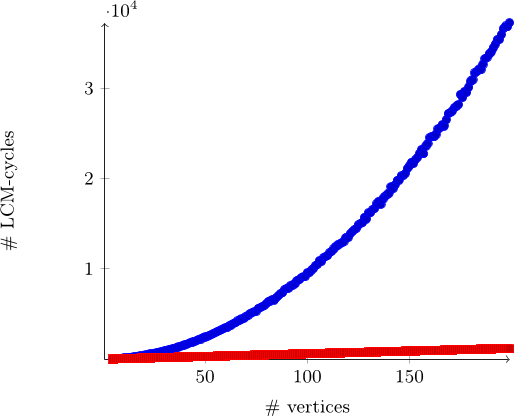

In [53]:
index=27
print("Image ID: ",X.iloc[index]['id'])
print("GT: ",X.iloc[index]['scitune_gt_text'])
# print("BLIP: ",X.iloc[index]['caption'])
print("SciTune: ",X.iloc[index]['scitune_text'])
image_file=X.iloc[index]['image']
image = Image.open(os.path.join(image_folder, image_file)).convert('RGB')
image

In [ ]:

results = metric.score_batch_qafacteval(["This is a source document"], [["This is a summary."]], return_qa_pairs=True)
score = results[0][0]['qa-eval']['lerc_quip']